In [95]:
import sys
print(sys.executable)

/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/bin/python


In [96]:
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM


In [97]:
fname = "tables/catalog_data_4FGL_DR4.h5"

with h5py.File(fname, "r") as f:
    # read attributes (if needed)
    E0 = f.attrs["E0"]

    # read assoc data
    alpha_as = f["assoc"]["alpha"][:]
    beta_as = f["assoc"]["beta"][:]
    flux_as = f["assoc"]["flux"][:]
    
    # read unassoc data
    alpha_unas = f["unas"]["alpha"][:]
    beta_unas = f["unas"]["beta"][:]
    flux_unas = f["unas"]["flux"][:]

- alpha → photon index (slope)
- beta → spectral curvature parameter
- flux → flux (or its log)

We can theoretically compute E_peak from this data: 
    E_peak_unas = E0 * 10 ** ((2 - alpha_unas) / (2 * beta_unas))

In [98]:
print('E0 (energy): attribute value', E0)
print('UNAS - alpha, beta & flux shape: ', alpha_unas.shape, beta_unas.shape, flux_unas.shape)
print('AS - alpha, beta & flux shape: ', alpha_as.shape, beta_as.shape, flux_as.shape)

E0 (energy): attribute value 1000
UNAS - alpha, beta & flux shape:  (1284,) (1284,) (1284,)
AS - alpha, beta & flux shape:  (3784,) (3784,) (3784,)


In [99]:
# Convert to pandas DataFrame

# Associated sources → training data
df_as = pd.DataFrame({
    'alpha': alpha_as,
    'beta': beta_as,
    'flux': flux_as
})

# Unassociated sources → data to predict
df_unas = pd.DataFrame({
    'alpha': alpha_unas,
    'beta': beta_unas,
    'flux': flux_unas
})

In [100]:
# Double check the data conversion
df_as.shape[0] == len(alpha_as)
df_unas.shape[0] == len(alpha_unas)

True

In [101]:
print(df_as.shape)
df_as.head()

(3784, 3)


,alpha,beta,flux
0,1.997826,0.049796,-8.922482
1,1.997502,0.037899,-8.018044
2,2.139592,-0.010222,-8.599896
3,2.865929,0.148901,-7.261064
4,1.338169,0.120901,-8.971793


In [102]:
print(df_unas.shape)
df_unas.head()

(1284, 3)


,alpha,beta,flux
0,1.984765,0.109999,-9.250384
1,2.176364,0.109660,-8.828196
2,0.902878,0.251122,-10.038708
3,2.098364,0.324241,-8.781500
4,2.086239,0.333186,-8.672857


In [103]:
print('Associated sources -------------------------')
df_as.describe()

Associated sources -------------------------


,alpha,beta,flux
count,3784.000000,3784.000000,3784.000000
mean,2.016049,0.119914,-8.467080
std,0.587186,0.122898,0.643259
min,-1.254197,-0.128125,-10.543907
25%,1.714093,0.040843,-8.843178
50%,2.092988,0.092526,-8.413159
75%,2.410078,0.164627,-8.070424
max,4.463546,0.796040,-6.154286


In [104]:
print('\nUnassociated sources -----------------------')
df_unas.describe()


Unassociated sources -----------------------


,alpha,beta,flux
count,1284.000000,1284.000000,1284.000000
mean,2.024184,0.182429,-8.746101
std,0.732372,0.165423,0.558917
min,-1.775794,-0.111614,-10.835591
25%,1.651657,0.054358,-9.102418
50%,2.142563,0.153545,-8.642136
75%,2.495624,0.300316,-8.335582
max,4.036645,0.746194,-7.366050


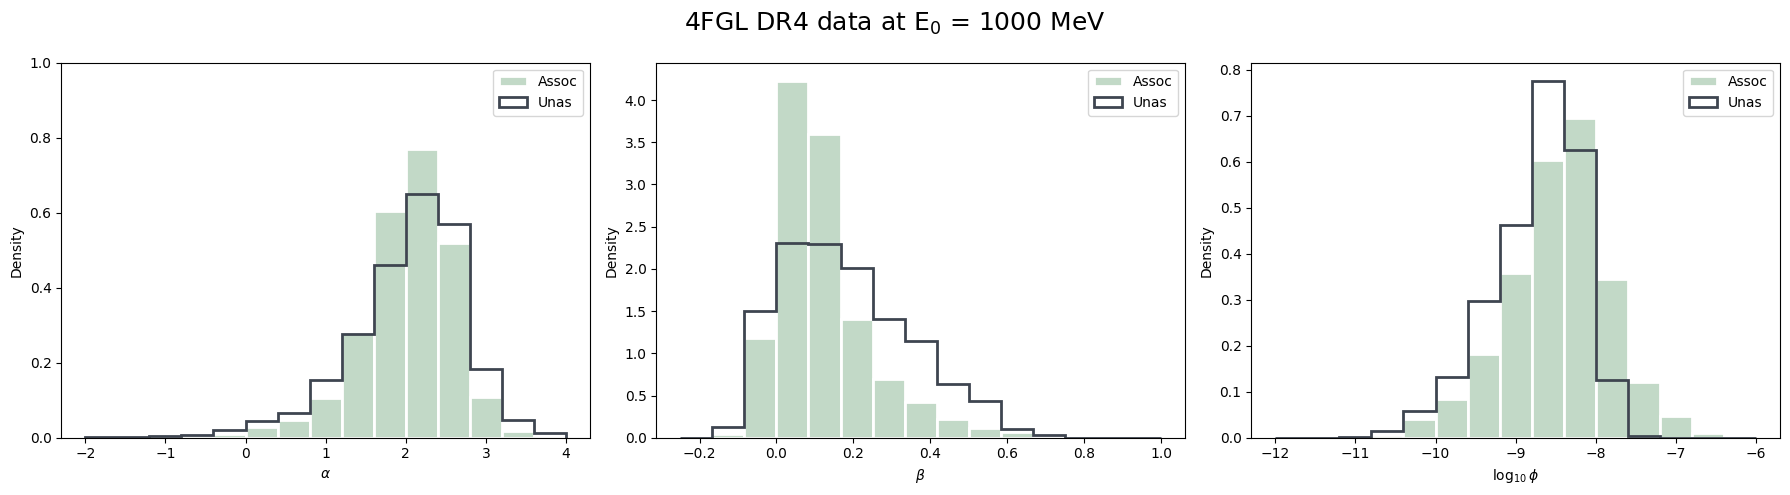

In [105]:
# Plot the data the same way to check the distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

nbins = 15
unas_color = "#3e4550"
as_color = "#c2d9c7"

fig.suptitle(r"4FGL DR4 data at E$_0$ = {:.0f} MeV".format(E0), fontsize=18)

# Alpha
axs[0].hist(df_as['alpha'], bins=nbins, range=[-2, 4], color=as_color, edgecolor="white", lw=2, density=True, label="Assoc")
axs[0].hist(df_unas['alpha'], bins=nbins, range=[-2, 4], histtype='step', edgecolor=unas_color, lw=2, density=True, label="Unas")
axs[0].set_xlabel(r"$\alpha$")
axs[0].set_ylabel("Density")
axs[0].legend()
axs[0].grid(0)
axs[0].set_ylim(0, 1.0)

# Beta
axs[1].hist(df_as['beta'], bins=nbins, range=[-0.25, 1.0], color=as_color, edgecolor="white", lw=2, density=True, label="Assoc")
axs[1].hist(df_unas['beta'], bins=nbins, range=[-0.25, 1.0], histtype='step', edgecolor=unas_color, lw=2, density=True, label="Unas")
axs[1].set_xlabel(r"$\beta$")
axs[1].set_ylabel("Density")
axs[1].legend()
axs[1].grid(0)

# Flux
axs[2].hist(df_as['flux'], bins=nbins, range=[-12, -6], color=as_color, edgecolor="white", lw=2, density=True, label="Assoc")
axs[2].hist(df_unas['flux'], bins=nbins, range=[-12, -6], histtype='step', edgecolor=unas_color, lw=2, density=True, label="Unas")
axs[2].set_xlabel(r"$\log_{10} \phi$")
axs[2].set_ylabel("Density")
axs[2].legend()
axs[2].grid(0)

plt.tight_layout()
plt.show()

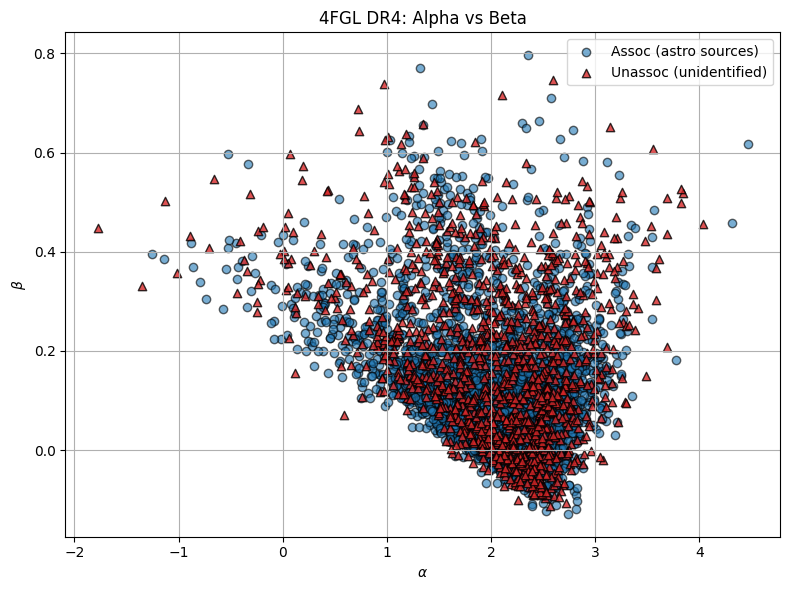

In [106]:
plt.figure(figsize=(8, 6))

# Plot associated sources
plt.scatter(
    df_as['alpha'], df_as['beta'],
    c='#1f77b4', label='Assoc (astro sources)', alpha=0.6, edgecolor='k'
)

# Plot unassociated sources
plt.scatter(
    df_unas['alpha'], df_unas['beta'],
    c='#d62728', label='Unassoc (unidentified)', alpha=0.8, edgecolor='k', marker='^'
)

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.title("4FGL DR4: Alpha vs Beta")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

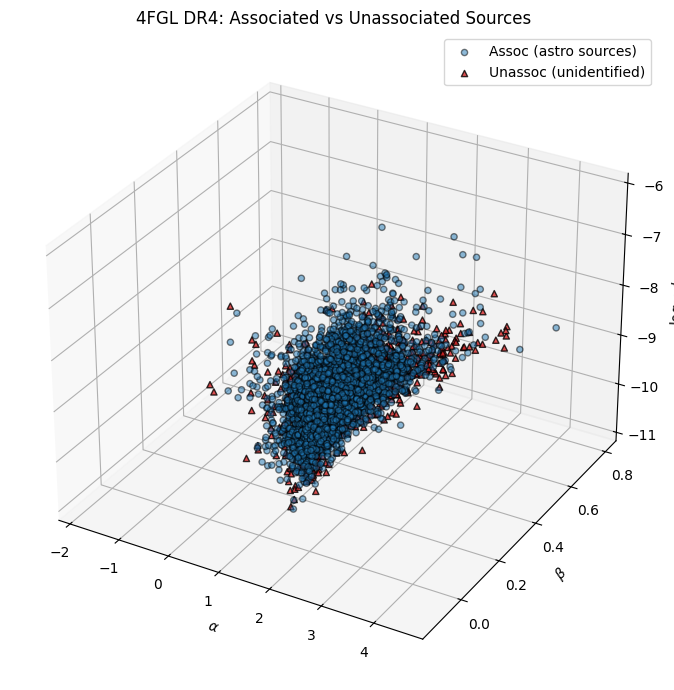

In [107]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Associated sources
ax.scatter(
    df_as['alpha'], df_as['beta'], df_as['flux'],
    c='#1f77b4', label='Assoc (astro sources)', alpha=0.5, edgecolor='k'
)

# Unassociated sources
ax.scatter(
    df_unas['alpha'], df_unas['beta'], df_unas['flux'],
    c='#d62728', label='Unassoc (unidentified)', alpha=0.8, edgecolor='k', marker='^'
)

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\log_{10} \phi$')
ax.set_title("4FGL DR4: Associated vs Unassociated Sources")

ax.legend()
plt.tight_layout()
plt.show()

In [108]:
df_plot = pd.concat([
    df_as.assign(Source='Assoc'),
    df_unas.assign(Source='Unassoc')
])

fig = px.scatter_3d(
    df_plot,
    x='alpha', y='beta', z='flux',
    color='Source',
    symbol='Source',
    opacity=0.7,
    title='4FGL DR4: Associated vs Unassociated Sources'
)

fig.show()

# Train the model - 3F OneClassSVM

In [109]:
# Select features, in this case we have no target variable (no y needed)
features = ['alpha', 'beta', 'flux']
X = df_as[features].values

In [110]:
# Split the data into training and test sets
X_train, X_temp = train_test_split(X, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(2270, 3) (757, 3) (757, 3)


In [111]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [112]:
# Hyperparameter tuning with hyperparameter grid search
nu_values = [0.005, 0.01, 0.02, 0.05]
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))

best_model = None
best_params = {}
best_score = np.inf  # minimize # of outliers

results = []

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)
        
        preds = model.predict(X_val_scaled)  # 1 = inlier, -1 = outlier
        n_outliers = np.sum(preds == -1)
        
        results.append({'nu': nu, 'gamma': gamma, 'outliers': n_outliers})
        
        if n_outliers < best_score:
            best_score = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

print(f"Best Params: nu={best_params['nu']}, gamma={best_params['gamma']}")
print(f"Outliers detected in val: {best_score}")

Best Params: nu=0.005, gamma=0.01
Outliers detected in val: 4


In [113]:
# get predictions + decision scores
preds = best_model.predict(X_val_scaled)
decision_scores = best_model.decision_function(X_val_scaled)

# index maxs
inlier_idx = preds == 1
outlier_idx = preds == -1

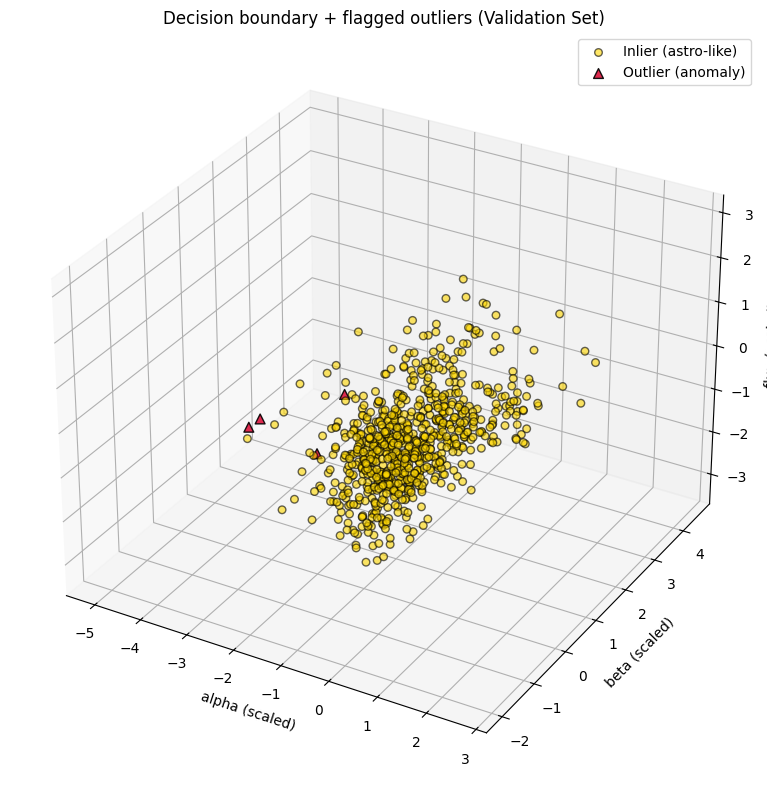

In [114]:
# Plot the distribution of inliers and outliers
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Inliers
ax.scatter(
    X_val_scaled[inlier_idx, 0],
    X_val_scaled[inlier_idx, 1],
    X_val_scaled[inlier_idx, 2],
    c='gold', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.6
)

# Outliers
ax.scatter(
    X_val_scaled[outlier_idx, 0],
    X_val_scaled[outlier_idx, 1],
    X_val_scaled[outlier_idx, 2],
    c='crimson', edgecolor='k', marker='^', s=50, label='Outlier (anomaly)', alpha=0.9
)

ax.set_xlabel('alpha (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('flux (scaled)')
ax.set_title("Decision boundary + flagged outliers (Validation Set)")

ax.legend()
plt.tight_layout()
plt.show()

In [115]:
# Highlight top outliers (anomalies)

# most anomalous = lowest decision score
top_idx = np.argsort(decision_scores)[:10]
for idx in top_idx:
    ax.scatter(
        X_val_scaled[idx, 0], X_val_scaled[idx, 1], X_val_scaled[idx, 2],
        facecolors='none', edgecolors='black', s=100, linewidths=2
    )
    ax.text(
        X_val_scaled[idx, 0], X_val_scaled[idx, 1], X_val_scaled[idx, 2] + 0.1,
        str(idx), color='black', fontsize=8
    )
    
plt.show()

## Test the model on the test set

In [116]:
# Evaluate final model on the test set
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)

print(f"🔍 Outliers in test set: {n_test_outliers}")

🔍 Outliers in test set: 5


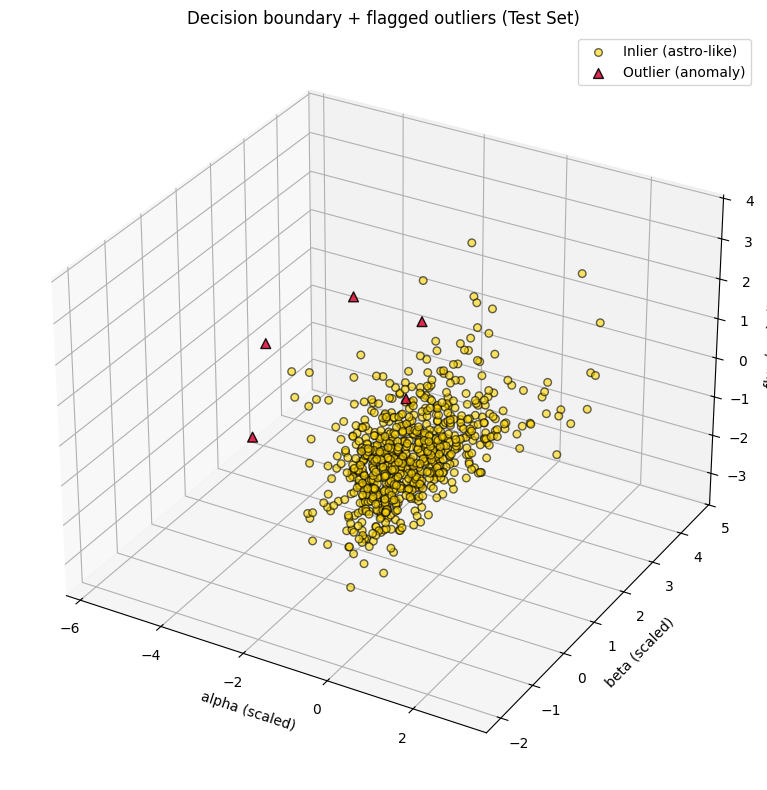

In [ ]:
# Visualize the test set
preds = best_model.predict(X_test_scaled)
decision_scores = best_model.decision_function(X_test_scaled)

# index maxs
inlier_idx = preds == 1
outlier_idx = preds == -1

# Plot the distribution of inliers and outliers
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Inliers
ax.scatter(
    X_test_scaled[inlier_idx, 0],
    X_test_scaled[inlier_idx, 1],
    X_test_scaled[inlier_idx, 2],
    c='gold', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.6
)

# Outliers
ax.scatter(
    X_test_scaled[outlier_idx, 0],
    X_test_scaled[outlier_idx, 1],
    X_test_scaled[outlier_idx, 2],
    c='crimson', edgecolor='k', marker='^', s=50, label='Outlier (anomaly)', alpha=0.9
)

ax.set_xlabel('alpha (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('flux (scaled)')
ax.set_title("Decision boundary + flagged outliers (Test Set)")

ax.legend()
plt.tight_layout()
plt.show()

# Predict on unassociated data

In [118]:
# Scale unassociated data
X_unas = df_unas[features].values
X_unas_scaled = scaler.transform(X_unas)

unas_preds = best_model.predict(X_unas_scaled)
decision_scores = best_model.decision_function(X_unas_scaled)
n_unas_outliers = np.sum(unas_preds == -1)

print(f"🔍 Outliers in unassociated data: {n_unas_outliers}")

🔍 Outliers in unassociated data: 16


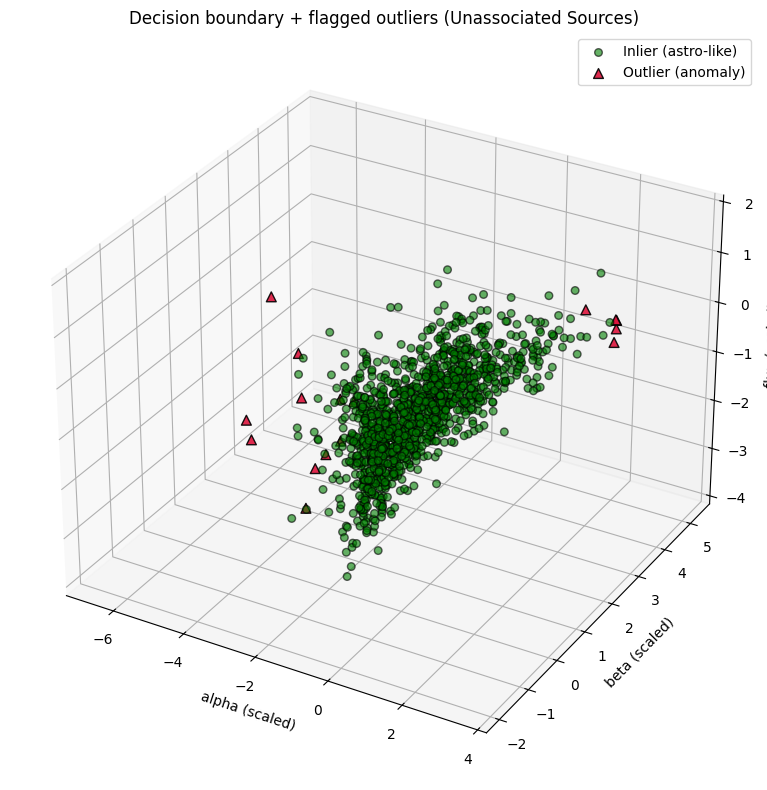

In [119]:
# index maxs
inlier_idx = unas_preds == 1
outlier_idx = unas_preds == -1

# Plot the distribution of inliers and outliers
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Inliers
ax.scatter(
    X_unas_scaled[inlier_idx, 0],
    X_unas_scaled[inlier_idx, 1],
    X_unas_scaled[inlier_idx, 2],
    c='green', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.6
)

# Outliers
ax.scatter(
    X_unas_scaled[outlier_idx, 0],
    X_unas_scaled[outlier_idx, 1],
    X_unas_scaled[outlier_idx, 2],
    c='crimson', edgecolor='k', marker='^', s=50, label='Outlier (anomaly)', alpha=0.9
)

ax.set_xlabel('alpha (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('flux (scaled)')
ax.set_title("Decision boundary + flagged outliers (Unassociated Sources)")

ax.legend()
plt.tight_layout()
plt.show()